In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from tag_recommender.utils.text import split_tags, to_snake_case_boosted

tqdm.pandas()

%matplotlib inline

In [2]:
# Read the full dataset. We only need a few columns for this analysis
df = pd.read_csv(
    "../data/full_dataset.csv",
    usecols=["type", "lang", "is_reblog", "tags", "root_tags"],
)

# Split tags strings into tag arrays (without normalization)
df["root_tags"] = df["root_tags"].fillna("").progress_apply(split_tags)
df["tags"] = df["tags"].fillna("").progress_apply(split_tags)

# Count the number of tags in each row
df["root_tags_count"] = df["root_tags"].progress_apply(len)
df["tags_count"] = df["tags"].progress_apply(len)
df["total_tags_count"] = df["root_tags_count"] + df["tags_count"]

# Fill NaN values in 'is_reblog' column with 0 to show that these posts are not re-blogged
df["is_reblog"] = df["is_reblog"].fillna(0)

# Create new column 'lang_type' to categorize languages as 'en' or 'other'
df["lang_type"] = df.lang.apply(lambda s: "en" if s == "en_US" else "other")
# Create new column 'type_bucket' to categorize the post-types as 'photo' or 'other'
df["type_bucket"] = df["type"].apply(lambda s: s if s == "photo" else "other")

df.head()

100%|██████████| 1764542/1764542 [00:00<00:00, 2853795.84it/s]


,type,lang,is_reblog,tags,root_tags,root_tags_count,tags_count,total_tags_count,lang_type,type_bucket
0,photo,en_US,1.0,"[me too sadie, sadie sink, stranger things cast]","[sadie sink, sadiesinkedit, femaledaily, daily...",15,3,18,en,photo
1,regular,en_US,0.0,"[it speaks, r: the end of nihility, r: on a ga...",[],0,3,3,en,other
2,video,en_US,0.0,[Youtube],[],0,1,1,en,other
3,photo,en_US,1.0,"[alchemy of souls, i miss them already]","[alchemy of souls, alchemy of souls: light and...",26,2,28,en,photo
4,photo,en_US,1.0,[tokyo revengers],"[manila mikey, manjiro sano, tokyo manji gang,...",21,1,22,en,photo


In [3]:
# Total number of posts
len(df)

1764542

In [4]:
# Filter out rows with no tags
df = df[(df["total_tags_count"] > 0)].reset_index(drop=True)
len(df)

1764527

In [5]:
# Calculate the distribution of the number of root tags per post
root_tags_counts_stats = (
    df["root_tags_count"].value_counts(normalize=True).sort_index().reset_index()
)
root_tags_counts_stats["cumsum %"] = root_tags_counts_stats.proportion.cumsum() * 100
root_tags_counts_stats

,root_tags_count,proportion,cumsum %
0,0,0.338854,33.885398
1,1,0.063555,40.240869
2,2,0.062307,46.471604
3,3,0.058422,52.313793
4,4,0.054251,57.738929
5,5,0.060526,63.791486
6,6,0.049172,68.708725
7,7,0.043829,73.091656
8,8,0.038162,76.907863
9,9,0.034291,80.336940


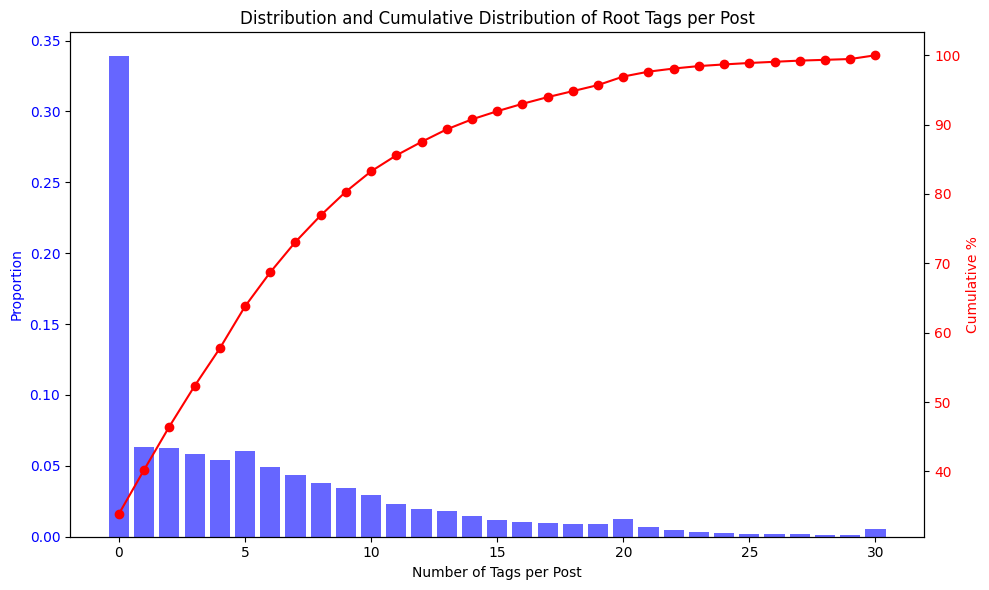

In [6]:
# Plotting the distribution and cumulative distribution of root tags per post

fig, ax1 = plt.subplots(figsize=(10, 6))
# Plot the distribution (proportion) on the left y-axis
ax1.bar(
    root_tags_counts_stats["root_tags_count"],
    root_tags_counts_stats["proportion"],
    color="b",
    alpha=0.6,
    label="Proportion",
)
ax1.set_xlabel("Number of Tags per Post")
ax1.set_ylabel("Proportion", color="b")
ax1.tick_params(axis="y", labelcolor="b")

# Create a second y-axis to plot the cumulative sum
ax2 = ax1.twinx()
ax2.plot(
    root_tags_counts_stats["root_tags_count"],
    root_tags_counts_stats["cumsum %"],
    color="r",
    marker="o",
    label="Cumulative %",
)
ax2.set_ylabel("Cumulative %", color="r")
ax2.tick_params(axis="y", labelcolor="r")

# Title and layout
plt.title("Distribution and Cumulative Distribution of Root Tags per Post")
fig.tight_layout()

# Show plot
plt.show()

In [7]:
# Calculate the distribution of the number of re-blogged tags per post
reblogged_tags_counts_stats = (
    df["tags_count"].value_counts(normalize=True).sort_index().reset_index()
)
reblogged_tags_counts_stats["cumsum %"] = (
    reblogged_tags_counts_stats.proportion.cumsum() * 100
)
reblogged_tags_counts_stats

,tags_count,proportion,cumsum %
0,0,5.667241e-07,0.000057
1,1,3.871355e-01,38.713604
2,2,2.249866e-01,61.212268
3,3,1.297470e-01,74.186963
4,4,7.430717e-02,81.617680
5,5,4.722852e-02,86.340532
6,6,3.268128e-02,89.608660
7,7,2.033803e-02,91.642463
8,8,1.419361e-02,93.061823
9,9,1.014663e-02,94.076486


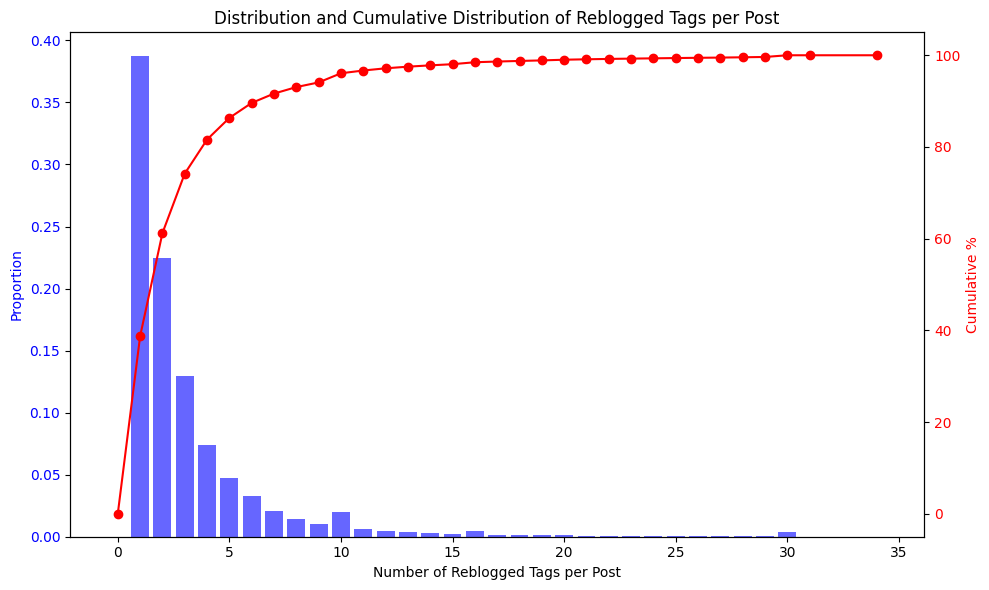

In [8]:
# Plotting the distribution and cumulative distribution of re-blogged tags per post
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the distribution (proportion) on the left y-axis
ax1.bar(
    reblogged_tags_counts_stats["tags_count"],
    reblogged_tags_counts_stats["proportion"],
    color="b",
    alpha=0.6,
    label="Proportion",
)
ax1.set_xlabel("Number of Reblogged Tags per Post")
ax1.set_ylabel("Proportion", color="b")
ax1.tick_params(axis="y", labelcolor="b")

# Create a second y-axis to plot the cumulative sum
ax2 = ax1.twinx()
ax2.plot(
    reblogged_tags_counts_stats["tags_count"],
    reblogged_tags_counts_stats["cumsum %"],
    color="r",
    marker="o",
    label="Cumulative %",
)
ax2.set_ylabel("Cumulative %", color="r")
ax2.tick_params(axis="y", labelcolor="r")

# Title and layout
plt.title("Distribution and Cumulative Distribution of Reblogged Tags per Post")
fig.tight_layout()

# Show plot
plt.show()

In [9]:
hashtags_counts = (
    pd.concat([df["root_tags"], df["tags"]])
    .explode()
    .dropna()
    .str.lower()
    .value_counts()
)
hashtags_counts

art                                                             110696
my art                                                           77000
fanart                                                           53664
*                                                                32919
mine                                                             32794
                                                                 ...  
also don't go planning on stealing any baby larvitars /lh /j         1
my body is a canvas                                                  1
the lights!                                                          1
op the lights                                                        1
what the hell am i gonna do when it’s done                           1
Name: count, Length: 2282228, dtype: int64

In [10]:
# Calculate the distribution of hashtags counts
counts_stats = hashtags_counts.value_counts(normalize=True).sort_index().reset_index()
counts_stats["cumsum %"] = counts_stats.proportion.cumsum() * 100
counts_stats

,count,proportion,cumsum %
0,1,7.045370e-01,70.453697
1,2,1.043721e-01,80.890910
2,3,4.598664e-02,85.489574
3,4,2.728167e-02,88.217742
4,5,1.803413e-02,90.021155
...,...,...,...
2024,32794,4.381683e-07,99.999825
2025,32919,4.381683e-07,99.999869
2026,53664,4.381683e-07,99.999912
2027,77000,4.381683e-07,99.999956


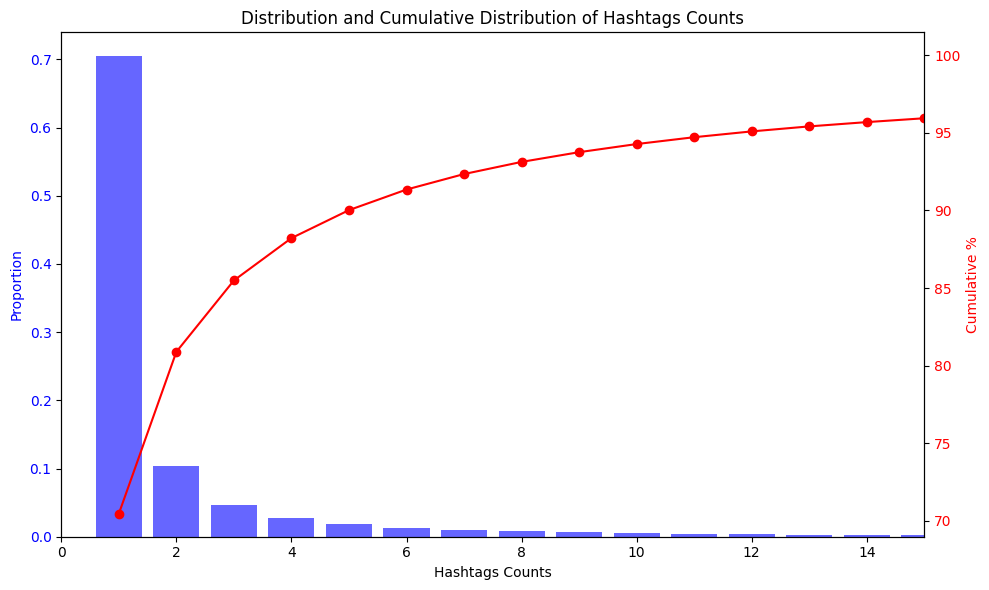

In [11]:
# Plotting the distribution and cumulative distribution of the hashtags counts
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the distribution (proportion) on the left y-axis
ax1.bar(
    counts_stats["count"],
    counts_stats["proportion"],
    color="b",
    alpha=0.6,
    label="Proportion",
)
ax1.set_xlabel("Hashtags Counts")
ax1.set_ylabel("Proportion", color="b")
ax1.tick_params(axis="y", labelcolor="b")
# set limit for x-axis
plt.xlim(0, 15)

# Create a second y-axis to plot the cumulative sum
ax2 = ax1.twinx()
ax2.plot(
    counts_stats["count"],
    counts_stats["cumsum %"],
    color="r",
    marker="o",
    label="Cumulative %",
)
ax2.set_ylabel("Cumulative %", color="r")
ax2.tick_params(axis="y", labelcolor="r")

# Title and layout
plt.title("Distribution and Cumulative Distribution of Hashtags Counts")
fig.tight_layout()

# Show plot
plt.show()

Let's check what happens if things change when we normalize the data

In [12]:
norm_hashtags_counts = (
    pd.concat([df["root_tags"], df["tags"]])
    .explode()
    .dropna()
    .progress_apply(to_snake_case_boosted)
    .value_counts()
)
norm_hashtags_counts

100%|██████████| 14698233/14698233 [02:24<00:00, 101681.59it/s]


art                                                                             111708
                                                                                102413
my_art                                                                           77744
fanart                                                                           53742
mine                                                                             42776
                                                                                 ...  
you_know_what_ill_actually_start_sabotaging_this_cb                                  1
katkat_im_already_in_tears_what_you_two_demond_want_from_me                          1
me_but_putting_my_phoneipad_password_wrong_enough_times_that_it_times_me_out         1
happy_the_cat                                                                        1
what_the_hell_am_i_gonna_do_when_its_done                                            1
Name: count, Length: 2178634, dtype: int64

In [13]:
# Calculate the distribution of normalized hashtags counts
norm_counts_stats = (
    norm_hashtags_counts.value_counts(normalize=True).sort_index().reset_index()
)
norm_counts_stats["cumsum %"] = norm_counts_stats.proportion.cumsum() * 100
norm_counts_stats

,count,proportion,cumsum %
0,1,6.991743e-01,69.917435
1,2,1.056731e-01,80.484744
2,3,4.668797e-02,85.153541
3,4,2.765999e-02,87.919540
4,5,1.835324e-02,89.754865
...,...,...,...
2012,42776,4.590032e-07,99.999816
2013,53742,4.590032e-07,99.999862
2014,77744,4.590032e-07,99.999908
2015,102413,4.590032e-07,99.999954


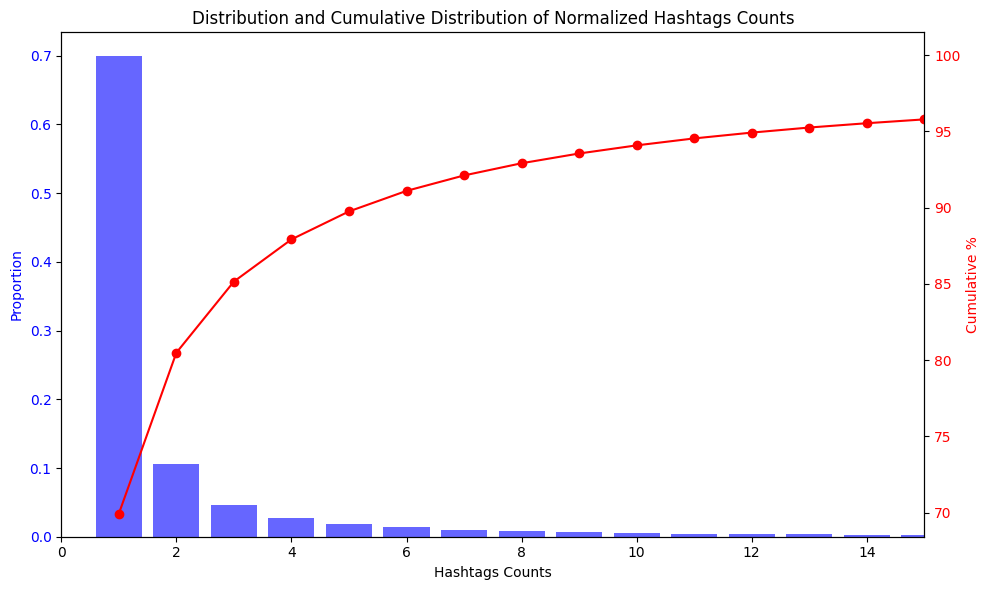

In [14]:
# Plotting the distribution and cumulative distribution of the normalized hashtags counts
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the distribution (proportion) on the left y-axis
ax1.bar(
    norm_counts_stats["count"],
    norm_counts_stats["proportion"],
    color="b",
    alpha=0.6,
    label="Proportion",
)
ax1.set_xlabel("Hashtags Counts")
ax1.set_ylabel("Proportion", color="b")
ax1.tick_params(axis="y", labelcolor="b")
# set limit for x-axis
plt.xlim(0, 15)

# Create a second y-axis to plot the cumulative sum
ax2 = ax1.twinx()
ax2.plot(
    norm_counts_stats["count"],
    norm_counts_stats["cumsum %"],
    color="r",
    marker="o",
    label="Cumulative %",
)
ax2.set_ylabel("Cumulative %", color="r")
ax2.tick_params(axis="y", labelcolor="r")

# Title and layout
plt.title("Distribution and Cumulative Distribution of Normalized Hashtags Counts")
fig.tight_layout()

# Show plot
plt.show()

In [15]:
for i in ["type", "lang"]:
    print(df[i].value_counts(normalize=True).reset_index())
    print()

           type  proportion
0         photo    0.608445
1       regular    0.252584
2         video    0.060315
3          link    0.025805
4          note    0.020675
5      photoset    0.018902
6         audio    0.006445
7         quote    0.004277
8  conversation    0.002553

     lang  proportion
0   en_US    0.910004
1   es_ES    0.019439
2   de_DE    0.014536
3   fr_FR    0.010736
4   pt_BR    0.010678
5   it_IT    0.007549
6   ru_RU    0.006003
7   pl_PL    0.005748
8   ja_JP    0.004640
9   nl_NL    0.003486
10  tr_TR    0.002976
11  pt_PT    0.001270
12  ko_KR    0.001013
13  id_ID    0.000691
14  zh_CN    0.000657
15  zh_TW    0.000368
16  zh_HK    0.000189
17  hi_IN    0.000017



In [16]:
# Define bins for 'tags_count' and 'root_tags_count'

max_tags_count = max(df["root_tags_count"].max(), df["tags_count"].max())
root_tag_bins = [0, 3, 10, 20, max_tags_count]
tag_bins = [0, 2, 5, 10, max_tags_count]

root_tag_bins, tag_bins

([0, 3, 10, 20, 34], [0, 2, 5, 10, 34])

In [17]:
from tag_recommender.process.utils import bucketize_col

# Create bucketized columns
df["root_tags_count_bucket"] = bucketize_col(df, "root_tags_count", root_tag_bins)
df["tags_count_bucket"] = bucketize_col(df, "tags_count", root_tag_bins)

In [18]:
df["root_tags_count_bucket"].value_counts(normalize=True).sort_index()

root_tags_count_bucket
(-0.001, 3.0]    0.523138
(3.0, 10.0]      0.309528
(10.0, 20.0]     0.136649
(20.0, 34.0]     0.030685
Name: proportion, dtype: float64

In [19]:
df["tags_count_bucket"].value_counts(normalize=True).sort_index()

tags_count_bucket
(-0.001, 3.0]    0.741870
(3.0, 10.0]      0.218848
(10.0, 20.0]     0.029555
(20.0, 34.0]     0.009727
Name: proportion, dtype: float64

In [20]:
from sklearn.model_selection import train_test_split


def stratified_split(
    df, stratify_cols, train_size=0.8, val_size=0.1, test_size=0.1, random_state=42
):
    # First split: Train and Remaining (Validation + Test)
    df_train, df_remaining = train_test_split(
        df, stratify=df[stratify_cols], train_size=train_size, random_state=random_state
    )

    # Calculate the proportion of validation set from remaining (Validation + Test)
    val_test_ratio = val_size / (val_size + test_size)

    # Second split: Validation and Test from the remaining data
    df_val, df_test = train_test_split(
        df_remaining,
        stratify=df_remaining[stratify_cols],
        test_size=val_test_ratio,
        random_state=random_state,
    )

    return df_train, df_val, df_test

In [21]:
import itertools


def get_all_combinations(arr: list) -> list[list[str]]:
    """
    Returns all combinations of all sizes from the input array of strings.

    Parameters
    ----------
    arr : list
        List of strings

    Returns
    -------
    list[list[str]]
        List of tuples, each containing a combination
    """
    all_combinations = []
    for r in range(1, len(arr) + 1):
        combinations = itertools.combinations(arr, r)
        all_combinations.extend(combinations)

    return list(all_combinations)


stratification_cols = [
    "tags_count_bucket",
    "root_tags_count_bucket",
    "type_bucket",
    "lang_type",
    "is_reblog",
]

get_all_combinations(stratification_cols)

[('tags_count_bucket',),
 ('root_tags_count_bucket',),
 ('type_bucket',),
 ('lang_type',),
 ('is_reblog',),
 ('tags_count_bucket', 'root_tags_count_bucket'),
 ('tags_count_bucket', 'type_bucket'),
 ('tags_count_bucket', 'lang_type'),
 ('tags_count_bucket', 'is_reblog'),
 ('root_tags_count_bucket', 'type_bucket'),
 ('root_tags_count_bucket', 'lang_type'),
 ('root_tags_count_bucket', 'is_reblog'),
 ('type_bucket', 'lang_type'),
 ('type_bucket', 'is_reblog'),
 ('lang_type', 'is_reblog'),
 ('tags_count_bucket', 'root_tags_count_bucket', 'type_bucket'),
 ('tags_count_bucket', 'root_tags_count_bucket', 'lang_type'),
 ('tags_count_bucket', 'root_tags_count_bucket', 'is_reblog'),
 ('tags_count_bucket', 'type_bucket', 'lang_type'),
 ('tags_count_bucket', 'type_bucket', 'is_reblog'),
 ('tags_count_bucket', 'lang_type', 'is_reblog'),
 ('root_tags_count_bucket', 'type_bucket', 'lang_type'),
 ('root_tags_count_bucket', 'type_bucket', 'is_reblog'),
 ('root_tags_count_bucket', 'lang_type', 'is_reblog

In [22]:
# collect all the stratification candidates the pass the minimum number of samples in the validation set
stratification_candidates = []

for stratify_cols in get_all_combinations(stratification_cols):
    try:
        stratified_split(df, stratify_cols=list(stratify_cols))
        stratification_candidates.append(list(stratify_cols))
    except ValueError:
        continue

# show the stratification candidates from the largest to the smallest
stratification_candidates.sort(key=len, reverse=True)

In [23]:
stratification_candidates

[['tags_count_bucket', 'root_tags_count_bucket', 'type_bucket', 'is_reblog'],
 ['tags_count_bucket', 'root_tags_count_bucket', 'lang_type', 'is_reblog'],
 ['tags_count_bucket', 'type_bucket', 'lang_type', 'is_reblog'],
 ['root_tags_count_bucket', 'type_bucket', 'lang_type', 'is_reblog'],
 ['tags_count_bucket', 'root_tags_count_bucket', 'type_bucket'],
 ['tags_count_bucket', 'root_tags_count_bucket', 'lang_type'],
 ['tags_count_bucket', 'root_tags_count_bucket', 'is_reblog'],
 ['tags_count_bucket', 'type_bucket', 'lang_type'],
 ['tags_count_bucket', 'type_bucket', 'is_reblog'],
 ['tags_count_bucket', 'lang_type', 'is_reblog'],
 ['root_tags_count_bucket', 'type_bucket', 'lang_type'],
 ['root_tags_count_bucket', 'type_bucket', 'is_reblog'],
 ['root_tags_count_bucket', 'lang_type', 'is_reblog'],
 ['type_bucket', 'lang_type', 'is_reblog'],
 ['tags_count_bucket', 'root_tags_count_bucket'],
 ['tags_count_bucket', 'type_bucket'],
 ['tags_count_bucket', 'lang_type'],
 ['tags_count_bucket', 'is_

In [24]:
# Tried to Perform the split using many columns, but it's failing due to the minimum number of samples in the validation set
# ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [25]:
df_training, df_validation, df_testing = stratified_split(
    df,
    stratify_cols=["root_tags_count_bucket", "type_bucket", "lang_type", "is_reblog"],
)

In [26]:
(
    df_training.shape[0] / len(df),
    df_validation.shape[0] / len(df),
    df_testing.shape[0] / len(df),
)

(0.7999996599655318, 0.10000017001723407, 0.10000017001723407)

In [27]:
df_training

,type,lang,is_reblog,tags,root_tags,root_tags_count,tags_count,total_tags_count,lang_type,type_bucket,root_tags_count_bucket,tags_count_bucket
199428,photo,it_IT,1.0,"[Tbb, gregor, Art, Clones, clones my beloved]",[I'm artblocked so even simple sketches are a ...,8,5,13,other,photo,"(3.0, 10.0]","(3.0, 10.0]"
424591,photo,en_US,1.0,"[doctor who, billie piper, david tennant, 10th...","[dwedit, doctor who, tenth doctor, rose tyler,...",10,5,15,en,photo,"(3.0, 10.0]","(3.0, 10.0]"
946242,photo,en_US,1.0,"[aftersun, movies]","[Aftersun, Charlotte Wells, Paul Mescal, Franc...",14,2,16,en,photo,"(10.0, 20.0]","(-0.001, 3.0]"
1083564,photo,en_US,1.0,"[Bulgaria, fascinating things, klek shops]","[sofia bulgaria shops, klik shops, kneeling sh...",4,3,7,en,photo,"(3.0, 10.0]","(-0.001, 3.0]"
456764,photo,en_US,1.0,[kenny omega],"[kenny omega, aew dynamite, aew]",3,1,4,en,photo,"(-0.001, 3.0]","(-0.001, 3.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
113232,regular,es_ES,0.0,[chaofan.txt],[],0,1,1,other,other,"(-0.001, 3.0]","(-0.001, 3.0]"
821261,regular,en_US,1.0,"[I needed this, thank you caps lock PSA, Engli...",[],0,3,3,en,other,"(-0.001, 3.0]","(-0.001, 3.0]"
941888,photo,en_US,1.0,[i so am gonna do this to my hair],"[hair inspo, hair inspiration, kpop aesthetic,...",8,1,9,en,photo,"(3.0, 10.0]","(-0.001, 3.0]"
1246537,photo,en_US,1.0,"[love in the villa, mark steven johnson, raymo...","[raymond ablack, love in the villa, mark steve...",4,5,9,en,photo,"(3.0, 10.0]","(3.0, 10.0]"
